# Generate an ensemble of ML models

We will attempt to model a portion of the empirical uncertainty that comes from the training data. To do this, we will generate 15 models. For each iteration, two flux tower sites  will be removed from the training data and an LGBM model will be fit on the remaining data.  This will result in 15 models that later we can use to make 15 predictions. The IQR envelope of our predictions will inform our uncertainity


## Load modules

In [1]:
import os
import shap
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats
import lightgbm as lgbm
from pprint import pprint
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from scipy.stats import gaussian_kde
from joblib import dump, parallel_backend, load
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, KFold

import warnings
warnings.filterwarnings("ignore")

Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead


## Analysis Parameters

In [2]:
model_var = 'NEE' #ER NEE ET
n_iter = 500 #how many hyperparameter iterations to test for the final model fitting?
n_models = 15 #how many iterations of models to create (iterations of training data)?
n_cpus = 24

base = '/g/data/os22/chad_tmp/AusEFlux/'

ec_exclusions=['DalyUncleared', 'RedDirtMelonFarm', 'Loxton']

modelling_vars = ['LST_RS', 'ΔT_RS',
                  'kNDVI_RS','kNDVI_anom_RS',
                  'NDWI_RS','NDWI_anom_RS',
                  'trees_RS', 'grass_RS', 'bare_RS', 'C4_grass_RS',
                  'rain_RS', 'rain_cml3_RS', 'rain_anom_RS',
                  'rain_cml3_anom_RS', 'rain_cml6_anom_RS', 'rain_cml12_anom_RS',
                  'SRAD_RS', 'SRAD_anom_RS',
                  'Tavg_RS', 'Tavg_anom_RS',
                  'VPD_RS', 'VPD_anom_RS',
                  'VegH_RS', 'site'
                ]

## Prepare Data

In [3]:
sites = os.listdir(f'{base}data/training_data/')

fluxes=['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC','ET_EC']

td = []
for site in sites:
    if '.csv' in site:
        if any(exc in site for exc in ec_exclusions): #don't load the excluded sites
            print('skip', site[0:-4])
            continue
        else:
            xx = pd.read_csv(f'{base}data/training_data/{site}', index_col='time', parse_dates=True)
            xx['site'] = site[0:-4]
            xx = xx[fluxes+modelling_vars]
            td.append(xx)

ts = pd.concat(td).dropna() #we'll use this later

skip DalyUncleared
skip Loxton
skip RedDirtMelonFarm


In [4]:
xx = []
yy = []

for t in td:    
    t = t.dropna()  # remove NaNS
    df = t.drop(['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC'], axis=1) # seperate carbon fluxes
    
    df = df[modelling_vars]
    
    if model_var == 'ET':
        df_var=t[[model_var+'_EC', 'site']]
    else:
        df_var=t[[model_var+'_SOLO_EC', 'site']] # seperate out the variable we're modelling
    
    x = df.reset_index(drop=True)#.to_numpy()
    y = df_var.reset_index(drop=True)#.to_numpy()
    xx.append(x)
    yy.append(y)

x = pd.concat(xx)
y = pd.concat(yy)

print(x.shape)

(3187, 24)


### Export features list

In [5]:
textfile = open(f'{base}results/variables.txt', 'w')
for element in x.columns:
    textfile.write(element + ",")
textfile.close()

## Generate iterations of models

For _n_ iterations, we remove two randomly selected sites from the training data.

Then, we do the per site TSCV: For each site, grab a sequential set of test samples (time-series-split methods), the remaining points (either side of test samples) go into training.  A single K-fold contains test and training samples from every site.

A model is built and saved that is trained of 15 iterations of site removal.


In [6]:
%%time
i=0
for m in range(1,n_models+1): # 15 iterations for each model
    print(" model {:02}/{:02}\r".format(m, len(range(1,n_models+1))))
          
    #randomly select two sites to remove from dataset
    subset=np.random.choice(x['site'].unique(), size=2)
    x_n = x[~x.site.isin(subset)]
    y_n = y[~y.site.isin(subset)]

    sites_n = x_n['site'].unique()
    x_n['original_index'] = [i for i in range(0,len(x_n))]
    
    #build TSCV splits across all remaining sites
    train_1=[]
    train_2=[]
    train_3=[]
    train_4=[]
    train_5=[]

    test_1=[]
    test_2=[]
    test_3=[]
    test_4=[]
    test_5=[]

    for site_n in sites_n:
        df = x_n.loc[x_n['site'] == site_n]
        tscv = TimeSeriesSplit(n_splits=5)
        i=1
        for train, test in tscv.split(df):
            all_indices=np.concatenate([train,test])
            left_over = df.loc[~df.index.isin(all_indices)].index.values
            train = np.concatenate([train, left_over])
            if i==1:
                train_1.append(df.iloc[train]['original_index'].values)
                test_1.append(df.iloc[test]['original_index'].values)
            if i==2:
                train_2.append(df.iloc[train]['original_index'].values)
                test_2.append(df.iloc[test]['original_index'].values)
            if i==3:
                train_3.append(df.iloc[train]['original_index'].values)
                test_3.append(df.iloc[test]['original_index'].values)
            if i==4:
                train_4.append(df.iloc[train]['original_index'].values)
                test_4.append(df.iloc[test]['original_index'].values)
            if i==4:
                train_5.append(df.iloc[train]['original_index'].values)
                test_5.append(df.iloc[test]['original_index'].values)
            i+=1

    train_1 = np.concatenate(train_1)
    train_2 = np.concatenate(train_2)
    train_3 = np.concatenate(train_3)
    train_4 = np.concatenate(train_4)
    train_5 = np.concatenate(train_5)

    test_1 = np.concatenate(test_1)
    test_2 = np.concatenate(test_2)
    test_3 = np.concatenate(test_3)
    test_4 = np.concatenate(test_4)
    test_5 = np.concatenate(test_5)

    train = [train_1, train_2, train_3, train_4, train_5]
    test = [test_1, test_2, test_3, test_4, test_5]

    #check there are no train indices in the test indices
    for i,j in zip(train, test):
        assert (np.sum(np.isin(i,j)) == 0)

    #remove the columns we no longer need
    x_n = x_n.drop(['site', 'original_index'], axis=1)
    y_n = y_n.drop('site', axis=1)

    #loop through the two regression methods
    for regressor in [LGBMRegressor,RandomForestRegressor]:
    
        if isinstance(regressor(), lgbm.sklearn.LGBMRegressor):
            m_name='_lgbm_'
        
            param_grid = {
                'num_leaves': stats.randint(5,40),
                'min_child_samples':stats.randint(10,30),
                'boosting_type': ['gbdt', 'dart'],
                'max_depth': stats.randint(5,25),
                'n_estimators': [300, 400, 500, 600],
            }
        
        else:
            m_name='_rf_'
    
            param_grid = {
                'max_depth': stats.randint(5,35),
                'max_features': ['log2', None, "sqrt"],
                'n_estimators': [300,400,500]}
    
        print('  Model:', m_name)
        
        #-----Nested CV to test accuracy-----------------------------------------------
        # results are saved as a .csv 
        j=1
        for train_index, test_index in zip(train, test):
            print(f"    {j}/{len(train)} outer cv split")
            
            #simple random split on inner fold
            inner_cv = KFold(n_splits=3,
                             shuffle=True,
                             random_state=0)
            
            # index training, testing
            X_tr, X_tt = x_n.iloc[train_index, :], x_n.iloc[test_index, :]
            y_tr, y_tt = y_n.iloc[train_index], y_n.iloc[test_index]
            
            if os.path.exists(f'{base}results/cross_val/{model_var}_ensemble/CV_{j}_{model_var}{m_name}{m}.csv'):
                j+=1
                continue
    
            with parallel_backend('threading', n_jobs=n_cpus):
                
                if m_name=='_rf_':
                    model = regressor(random_state=1, verbose=0)
                    clf = RandomizedSearchCV(
                                   model,
                                   param_grid,
                                   verbose=0,
                                   n_iter=int(n_iter/10),
                                   n_jobs=n_cpus,
                                   cv=inner_cv.split(X_tr, y_tr),
                                  )
                    
                    clf.fit(X_tr, y_tr.values.ravel())
                
                else:
                    model = regressor(random_state=1, verbose=-1)
                    clf = RandomizedSearchCV(
                                   model,
                                   param_grid,
                                   verbose=0,
                                   n_iter=int(n_iter/10),
                                   n_jobs=n_cpus,
                                   cv=inner_cv.split(X_tr, y_tr),
                                  )
                    
                    clf.fit(X_tr, y_tr, callbacks=None)
        
                # predict using the best model
                best_model = clf.best_estimator_
                pred = best_model.predict(X_tt)
            
            dff = pd.DataFrame({'Test':y_tt.values.squeeze(), 'Pred':pred}).reset_index(drop=True)
            dff.to_csv(f'{base}results/cross_val/{model_var}_ensemble/CV_{j}_{model_var}{m_name}{m}.csv')
    
            j+=1
        #-----End of Nested CV ---------------------------------------------------
        
        if os.path.exists(f'{base}results/models/ensemble/{model_var}/{model_var}{m_name}{m}.joblib'):
            print('    model already exists')
            continue
    
        # Now conduct a hyperparameter test on all the data
        # (minus the two removed sites) and fit a model
        print('    fit model and export')
        
        with parallel_backend('threading', n_jobs=n_cpus):
            
            if m_name=='_rf_':
                model = regressor(random_state=1, verbose=0)
                clf = RandomizedSearchCV(
                               model,
                               param_grid,
                               verbose=0,
                               n_iter=int(n_iter/10),
                               n_jobs=n_cpus,
                               cv=inner_cv.split(x_n, y_n),
                              )
                
                clf.fit(x_n, y_n.values.ravel())
                
            else:
                model = regressor(random_state=1, verbose=-1)
                clf = RandomizedSearchCV(
                               model,
                               param_grid,
                               verbose=0,
                               n_iter=int(n_iter/10),
                               n_jobs=n_cpus,
                               cv=inner_cv.split(x_n, y_n),
                              )
                
                clf.fit(x_n, y_n, callbacks=None)
            
            model = regressor(**clf.best_params_)
            model.fit(x_n, y_n)    
    
        dump(model, f'{base}results/models/ensemble/{model_var}/{model_var}{m_name}{m}.joblib')

    i+=1

 model 01/15
  Model: _lgbm_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    model already exists
  Model: _rf_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    model already exists
 model 02/15
  Model: _lgbm_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    model already exists
  Model: _rf_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    model already exists
 model 03/15
  Model: _lgbm_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    model already exists
  Model: _rf_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    model already exists
 model 04/15
  Model: _lgbm_
  

## Validation and feature importance plots

In [7]:
df_list=[]
r2_list=[]
ac_list=[]
#get the list of cvs corresponding with a given CV split
csvs = [i for i in os.listdir(f'{base}results/cross_val/{model_var}_ensemble/') if i.endswith('.csv')]
for i in csvs:
    df = pd.read_csv(f'{base}results/cross_val/{model_var}_ensemble/{i}', usecols=['Test', 'Pred'])
    obs,pred = df['Test'].values, df['Pred'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2_list.append(r_value**2)
    ac_list.append(mean_absolute_error(obs, pred))
    df_list.append(df)

#concantenate all the data  for the given CV split
cross_df = pd.concat(df_list)

### Calculate stats

In [8]:
obs,pred = cross_df['Test'].values, cross_df['Pred'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
r2 = r_value**2
ac = mean_absolute_error(obs, pred)

### Create figure

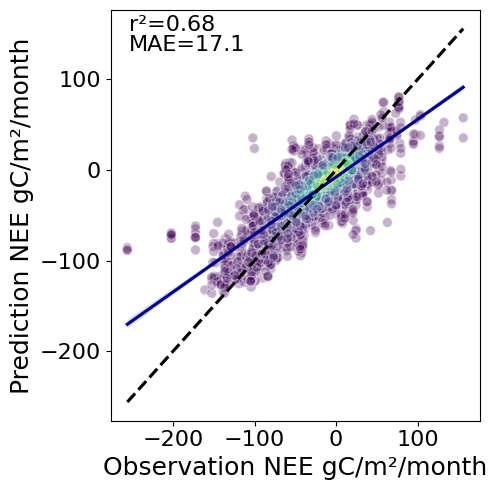

In [9]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
font=16
cross_df = cross_df.sample(n=4000)

xy = np.vstack([cross_df['Test'],cross_df['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=cross_df, x='Test',y='Pred',c=z, s=50, lw=1, alpha=0.3, ax=ax)
sb.regplot(data=cross_df, x='Test',y='Pred', scatter=False, color='darkblue', ax=ax)
sb.regplot(data=cross_df, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax);

if model_var !='ET':
    units = ' gC/m\N{SUPERSCRIPT TWO}/month'
else:
    units = ' mm/month'

plt.xlabel('Observation '+ model_var + units, fontsize=18)
plt.ylabel('Prediction ' + model_var+ units, fontsize=18)

ax.text(.05, .95, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=font)
ax.text(.05, .9, 'MAE={:.3g}'.format(ac),
            transform=ax.transAxes, fontsize=font)
ax.tick_params(axis='x', labelsize=font)
ax.tick_params(axis='y', labelsize=font)

plt.tight_layout()
fig.savefig(f'{base}results/cross_val/{model_var}_ensemble/cross_val_{model_var}_ensemble.png',
            bbox_inches='tight', dpi=300)

### Ensemble feature importance

Derived by calculating the mean absolute SHAP values for each feature in each model iteration, and subsequently averaging those values across all the models in the ensemble.

LGBM model run quickly, the RF models ru 

In [10]:
models_folder = f'{base}results/models/ensemble/{model_var}/'
model_list = [file for file in os.listdir(models_folder) if file.endswith(".joblib")]

In [11]:
# #remove the columns we no longer need
x = x.drop(['site'], axis=1)
y = y.drop(['site'], axis=1)

dffs=[]
i=1
for m in model_list:
    print(f"{i}/{len(model_list)}", end='\r')
    
    explainer = shap.TreeExplainer(model = load(models_folder+m))
    
    shap_values = explainer(x)
    vals = np.abs(shap_values.values).mean(0)
    df = pd.DataFrame(list(zip(x.columns, vals)), columns=['col_name',m[0:-7]+'_FI'])
    df.sort_values(by=[m[0:-7]+'_FI'],ascending=False,inplace=True)
    df['col_name'] = df['col_name'].str.removesuffix("_RS")
    df = df.set_index('col_name', drop=True)
    dffs.append(df)
    i += 1

df = pd.concat(dffs, axis=1)
df['mean'] = df.mean(axis=1)
df = df.T

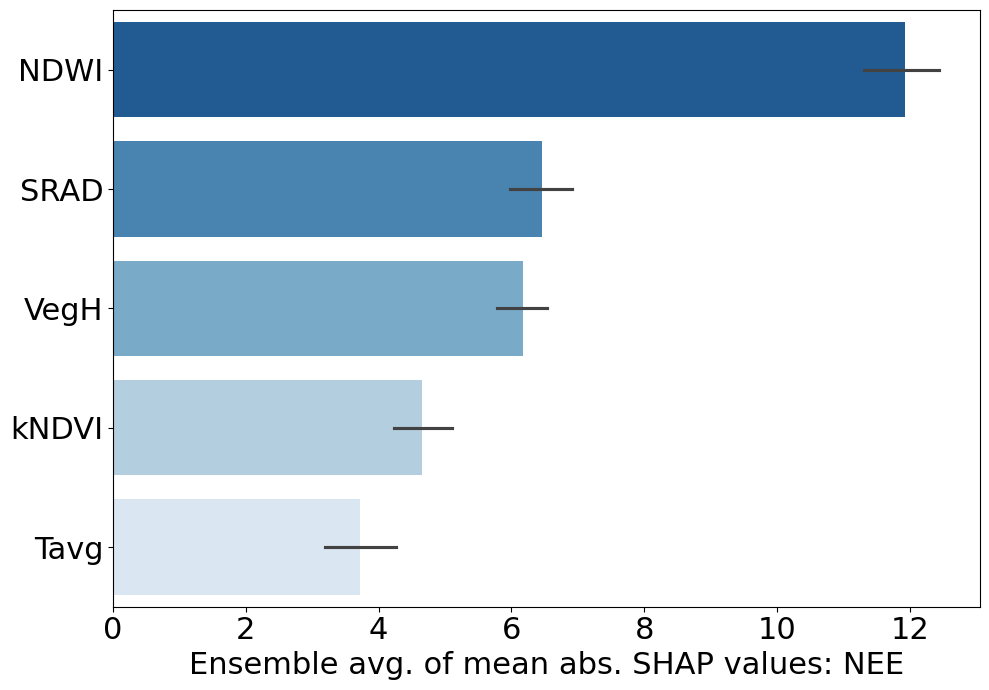

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
sb.barplot(data = df.sort_values(by='mean', axis=1, ascending=False).iloc[:, : 5].iloc[0:30], orient='h', ax=ax, palette='Blues_r')
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.set_xlabel('Ensemble avg. of mean abs. SHAP values: '+model_var, fontsize=22)
ax.set_ylabel('')
plt.tight_layout()
fig.savefig(f'{base}results/cross_val/{model_var}_ensemble/feature_importance_{model_var}_ensemble.png',
            bbox_inches='tight', dpi=300)